# MHKit Short-term Extreme Loads

Short-term extreme loads are typically required as part of a long-term extreme load estimate. 
A short-term extreme distribution is a probability distribution for the extreme value of a short-term (e.g. 3-hours) time-series. 

MHKiT includes functions adapted from the [WDRT](https://github.com/WEC-Sim/WDRT) for estimating the short-term extreme distribution. 
Several methods are included, which can be divided into two main  approaches:

1. Block maxima: approximate the short-term extreme distribution directly by fitting a probability distribution to the maxima from N distinct short-term blocks. 
2. Peaks distribution: approximate the short-term extreme distribution from the distribution of peaks from a time-series of arbitrary length. 

The two sets of methods will be demonstrated. 

**NOTE**: This notebook will walk through the two different approaches, and each method in them. The short-term extremes will be obtained step-by-step showing the intermediate outputs. However, a convenience function, the `loads.extreme.short_term_extreme` function, can be be used directly in a single step. For this usage jump to the last section. It is recommended that you go over this entire example to understand what is going on "under the hood" prior to using this convenience function. 

The quantity (load) of interest can be anything related to the WEC, such as position (e.g. PTO extension, heave displacement), velocity, structural load, mooring loads, etc. 
For this example we will use the wave elevation as the quantity of interest, since such time-series can be easily created without having to run a WEC-modeling software. 
The short-term period of interest will be 3-hours.

An important pre-processing step is making the time-series zero-mean. 
In this case, since wave elevation is zero-mean no pre-processing is needed.


We  will start by importing the `loads.extreme` module which includes these different methods, and  the `wave.resource` module to create the response time-series. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mhkit.loads import extreme 
from mhkit.wave.resource import jonswap_spectrum, surface_elevation

We first define the short-term period (3 hours).

In [2]:
# short-term period in seconds
t_st = 3.0 * 60.0 * 60.0 

The methods based on peaks distributions require a single time series of any length while the methods based on block maxima require N time series of length equal to the short-term time period. 

We will now create N=10 time series of length equal to the short-term period (3 hours). For block maxima methods we will use all 10 and for peaks distribution methods we will only use the first hour of the first time-series. For the block maxima we use N=10 for speed considerations, but note that this would be inadequately small for most real applications. 

For the sake of example we will consider the wave elevation as the quantity of interest (can be thought as a proxy for heave motion in this example). 
Wave elevation time-series for a specific sea state can be created quickly without running any external software. 

**NOTE:** The code below is simply creating the synthetic data (wave elevation time series). In a realistic case the time series would be obtained externally, e.g. through simulation software such as WEC-Sim or CFD. For this reason the details of creating the synthetic data are not presented here, instead assume for the quantity of interest there are ten 3-hours time-series available. 

We start by creating the ten 3-hour time-series of  the  quantity of interest. We do this with a list comprehension and using the `wave.resource.surface_elevation` function. The result is a list of 10 different time-series. Alternatively we could have created a single time-series of length N times the short-term period (30 hours) and used the `extreme.block_maxima` function to split it into blocks and return the block maxima. 

In [3]:
# JONSWAP spectrum for creating short-term time-series
T_min = 1  # s
Tp = 8  # s
Hs = 1.5  # m
f0 = 1/t_st
f_max = 1/T_min
Nf = int(f_max/f0)
f = np.linspace(f0, f_max, Nf)
S = jonswap_spectrum(f, Tp, Hs)

# time in seconds
time = np.linspace(0, t_st, 2*Nf+1)

# 10 distinct time-series
N = 10
qoi_timeseries = [surface_elevation(
    S, time).values.squeeze() for i in range(N)]

We can view the different time-series. Change value of `i` below to plot a different time-series. Below we plot both the full 3 hours time series and the first 2 minutes to get a better look at the behavior of the response.

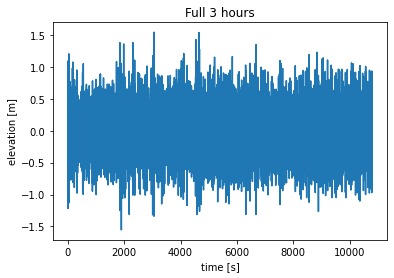

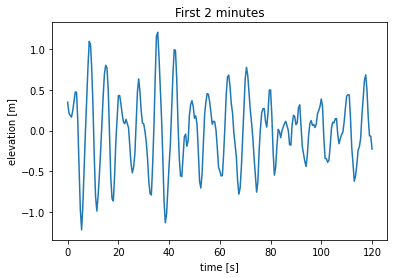

In [4]:
i = 0  # 0–9

plt.figure()
timeseries = qoi_timeseries[i]
plt.plot(time, timeseries)
plt.title("Full 3 hours")
plt.xlabel('time [s]')
plt.ylabel('elevation [m]')

plt.figure()
timeseries = qoi_timeseries[i]
plt.plot(time[time <= 120], timeseries[time <= 120])
plt.title("First 2 minutes")
plt.xlabel('time [s]')
plt.ylabel('elevation [m]');

## Block Maxima 
The short-term extreme distribution can be estimated directly from N time-series of short-term period. 
These time-series can be obtained, for instance, from N distinct simulations of the quantity of interest, or alternatively by dividing a long time-series of the quantity of interest  into blocks of length equal to the short-term period. In this example we will use N=10 for speed considerations, but this would be inadequately small for most real applications. 

### 1. Find the maximum of each block.
The first step is to get the maximum in each block, i.e. in each of the ten time series. We do this with a list comprehension. The result is a list of the 10 block maxima.

In [5]:
block_maxima = [np.max(time_series) for time_series in qoi_timeseries]
block_maxima = np.array(block_maxima)
block_maxima

array([1.54604643, 1.467073  , 1.57427583, 1.45417816, 1.44266541,
       1.35937156, 1.33657588, 1.41939984, 1.53371198, 1.41075921])

We can view the different time-series and their maxima. Change value of i below to plot a different time-series. 

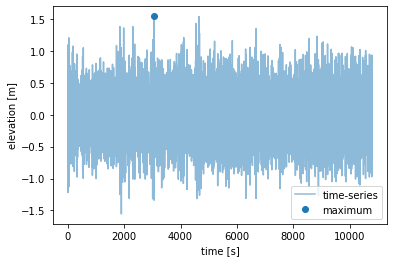

In [6]:
i = 0  # select: 0-9

plt.figure()
line, = plt.plot(time, qoi_timeseries[i], alpha=0.5, label='time-series')
plt.plot(time[np.argmax(qoi_timeseries[i])], block_maxima[i],
            'o', color=line.get_color(), label='maximum')
plt.xlabel('time [s]')
plt.ylabel('elevation [m]')
plt.legend();

We can also look at the 10 block maximas. Each point represent the largest elevation from one of the 10 time-series.

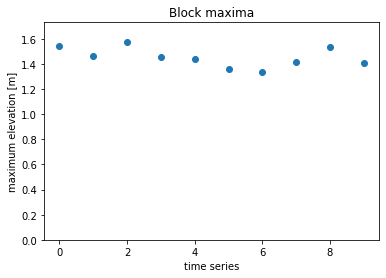

In [7]:
plt.figure()
plt.plot(block_maxima, 'o')
plt.title("Block maxima")
plt.xlabel('time series')
plt.ylabel('maximum elevation [m]')
plt.ylim([0, np.max(block_maxima*1.1)]);

### 2. Fit a distribution to the block maxima
We can now get the short-term extreme distribution by fitting either a generalized extreme value distribution or a Gumbel (right) distributions to these N=10 maxima. 
We will compare both methods. 

In [8]:
# generalized extreme value distribution
ste_gev = extreme.ste_block_maxima_gev(block_maxima)
# Gumbel (right) distribution
ste_gum = extreme.ste_block_maxima_gumbel(block_maxima)

The outputs of these functions are probability distributions (`scipy.stats.rv_continuous`). 
These objects provide common statistical functions (PDF, CDF, PPF, etc.) and metrics (expected value, median, etc). Here we will plot the CDF and PDF (including the 10 samples represented by the black dots) and print the expected value and 95% interval for both methods. The expected value for both is about 1.49 meters.

GEV:
  Expected value: 1.4539484564137006 m
  95% interval: (1.3049051355780483 m, 1.5837252119008833 m)
Gumbel:
  Expected value: 1.4562830217935439 m
  95% interval: (1.3303537374571037 m, 1.663587600246415 m)


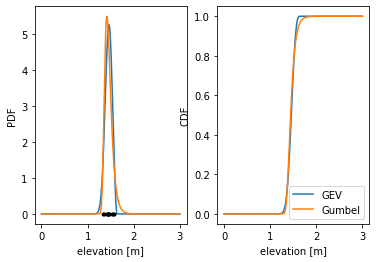

In [9]:
# print distribution statistics
print(f'GEV:\n  Expected value: {ste_gev.expect()} m\n  95% interval: ({ste_gev.ppf(0.025)} m, {ste_gev.ppf(0.975)} m)')
print(f'Gumbel:\n  Expected value: {ste_gum.expect()} m\n  95% interval: ({ste_gum.ppf(0.025)} m, {ste_gum.ppf(0.975)} m)')

# plot CDF and PDF
x = np.linspace(0, 3, 1000)
fig, axs = plt.subplots(1,2)
axs[0].plot(x, ste_gev.pdf(x))
axs[0].plot(x, ste_gum.pdf(x))
axs[0].plot(block_maxima, np.zeros(N), 'k.')
axs[1].plot(x, ste_gev.cdf(x), label='GEV')
axs[1].plot(x, ste_gum.cdf(x), label='Gumbel')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('elevation [m]')
axs[1].set_xlabel('elevation [m]');

## Peaks Distribution
The block maxima approach is the most direct way to approximate the short-term extreme but it requires a lot of data (N timeseries of length equal to the short-term period). 
An alternative approach approximates the short-term extreme from a timeseries of arbitrary length, even shorter than the short-term period, by fitting a distribution to the peaks of the timeseries. 

To demonstrate these methods we will approximate the 3-hour short-term extreme distribution from a single 1-hour timeseries. 

We start by generating this 1-hour response timeseries.

In [10]:
t_end = 1.0 * 60.0 * 60.0
timeseries_1hr = qoi_timeseries[0][time<t_end]
time_1hr = time[time < t_end]

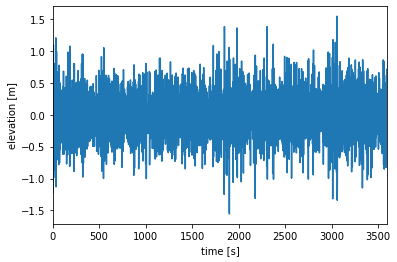

In [11]:
plt.figure()
plt.plot(time_1hr, timeseries_1hr)
plt.xlabel('time [s]')
plt.ylabel('elevation [m]')
plt.xlim([0, t_end]);

### 1. Find the global peaks
The global peaks are the maximum between succesive zero-upcrossings. 
We use the `extreme.global_peaks` function  to find these peaks. 

In [12]:
t_peaks, qoi_peaks = extreme.global_peaks(time_1hr, timeseries_1hr)
npeaks = len(qoi_peaks)

We will plot the entire time-series and the global peaks.

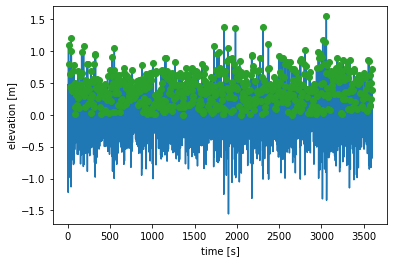

In [13]:
fig = plt.figure()

plt.plot([0, t_end], [0, 0], color='tab:grey')
plt.plot(time_1hr, timeseries_1hr, color='tab:blue')
plt.plot(t_peaks, qoi_peaks, 'o', color='tab:green')
plt.xlabel('time [s]')
plt.ylabel('elevation [m]');

We will also plot the first 2 minutes to get a better look at what is going on.

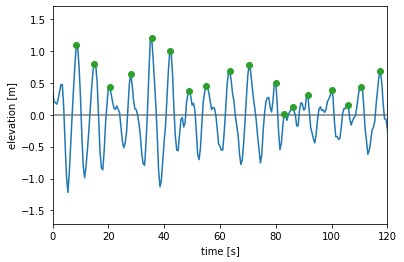

In [14]:
fig = plt.figure()

plt.plot([0, t_end], [0, 0], color='tab:grey')
plt.plot(time_1hr, timeseries_1hr, color='tab:blue')
plt.plot(t_peaks, qoi_peaks, 'o', color='tab:green')
plt.xlabel('time [s]')
plt.ylabel('elevation [m]')
plt.xlim([0, 120]);

### 2. Fit a distribution to the peaks

MHKiT has three methods for doing this. 

1. Fit a Weibull distribution to all the peaks. 
2. Weibull tail fit: seven different weibull distributions are fit to successively smaller subsets of the highest peaks, and the peak distribution is taken as the average of these seven. 
3. Peaks over threshold: a generalized Pareto distribution is fit to all peaks above a certain threshold, typically taken as 1.4 standard deviations above the mean. 

We will now compare the results from these three methods. For the peaks over threshold we will take the threshold (variable `thresh` below) to be 1.4 standard deviations above the mean.

In [15]:
# Weibull
peaks_w = extreme.peaks_distribution_weibull(qoi_peaks)

# Weibull tail fit
peaks_wtf = extreme.peaks_distribution_weibull_tail_fit(qoi_peaks)

# peaks over threshold
thresh = np.mean(qoi_peaks) + 1.4 * np.std(qoi_peaks)
peaks_pot = extreme.peaks_distribution_peaks_over_threshold(qoi_peaks, thresh)

The outputs are again `stats.rv_continuous` distributions. 
We will plot both the PDF (with the raw peak data shown as black dots) and CDF of the peaks distribution, and obtain the expected value and 95% interval for each distribution. Note however that for the peaks over threshold method the distribution is only defined for values over the threshold, and many of the functionalities that require the entire distribution (e.g. expected value) are therefor not available. 

Weibull:
  Expected value: 0.42994843847996356
  95% interval: (0.04643388017403304, 1.0964882950671226)
Weibull tail fit:
  Expected value: 0.4488922633713867
  95% interval: (0.07565935519410608, 0.9939086430385311)


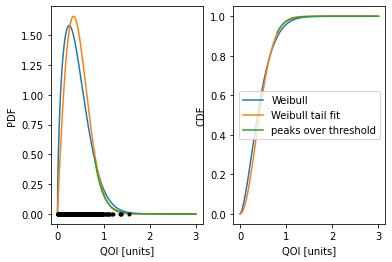

In [16]:
print(f'Weibull:\n  Expected value: {peaks_w.expect()}\n  95% interval: ({peaks_w.ppf(0.025)}, {peaks_w.ppf(0.975)})')
print(f'Weibull tail fit:\n  Expected value: {peaks_wtf.expect()}\n  95% interval: ({peaks_wtf.ppf(0.025)}, {peaks_wtf.ppf(0.975)})')

fig, axs = plt.subplots(1,2)
axs[0].plot(x, peaks_w.pdf(x))
axs[0].plot(x, peaks_wtf.pdf(x))
axs[0].plot(x, peaks_pot.pdf(x))
axs[0].plot(qoi_peaks, np.zeros(npeaks), 'k.')
axs[1].plot(x, peaks_w.cdf(x), label='Weibull')
axs[1].plot(x, peaks_wtf.cdf(x), label='Weibull tail fit')
axs[1].plot(x, peaks_pot.cdf(x), label='peaks over threshold')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('QOI [units]')
axs[1].set_xlabel('QOI [units]');

### 3. Obtain the short-term extreme distribution from the peaks distribution

We do this using the peaks distribution and an approximation for the number of peaks per short-term period. 
We use the `extreme.ste_peaks` function to obtain an approximation for the number of peaks in a short-term period.   

In [17]:
N_st = extreme.number_of_short_term_peaks(npeaks, t_end, t_st)
print(f"Approximate number of peaks in a (3-hours) short-term period: {N_st}")

ste_w = extreme.ste_peaks(peaks_w, N_st)
ste_wtf = extreme.ste_peaks(peaks_wtf, N_st)
ste_pot = extreme.ste_peaks(peaks_pot, N_st)

Approximate number of peaks in a (3-hours) short-term period: 1851.0


Again the outputs are `stats.rv_continuous` distributions for the short-term extreme. We will again plot the PDF and CDF and obtain the expected values and confidence intervals for each method. 

C:\Users\hivanov\AppData\Local\Continuum\anaconda3\envs\MHKdev\lib\site-packages\scipy\stats\_distn_infrastructure.py:2738: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  vals = integrate.quad(fun, lb, ub, **kwds)[0] / invfac


Weibull:
  Expected value: 1.8015746515403694
  95% interval: (1.5274922894251206, 2.218869399911306)
Weibull tail fit:
  Expected value: 1.4882943596679838
  95% interval: (1.3020212588619686, 1.764801679403271)
Peaks over threshold:
  Expected value: 1.6890855491151695
  95% interval: (1.4147174341282949, 2.1125268120706844)


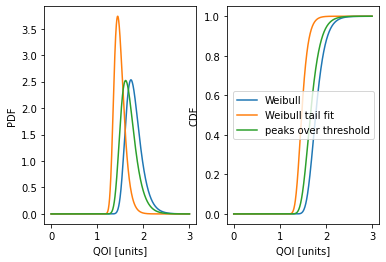

In [18]:
print(f'Weibull:\n  Expected value: {ste_w.expect()}\n  95% interval: ({ste_w.ppf(0.025)}, {ste_w.ppf(0.975)})')
print(f'Weibull tail fit:\n  Expected value: {ste_wtf.expect()}\n  95% interval: ({ste_wtf.ppf(0.025)}, {ste_wtf.ppf(0.975)})')
print(f'Peaks over threshold:\n  Expected value: {ste_pot.expect()}\n  95% interval: ({ste_pot.ppf(0.025)}, {ste_pot.ppf(0.975)})')

fig, axs = plt.subplots(1,2)
axs[0].plot(x, ste_w.pdf(x))
axs[0].plot(x, ste_wtf.pdf(x))
axs[0].plot(x, ste_pot.pdf(x))
axs[1].plot(x, ste_w.cdf(x), label='Weibull')
axs[1].plot(x, ste_wtf.cdf(x), label='Weibull tail fit')
axs[1].plot(x, ste_pot.cdf(x), label='peaks over threshold')
axs[0].set_ylabel('PDF')
axs[1].set_ylabel('CDF')
axs[1].legend()
axs[0].set_xlabel('QOI [units]')
axs[1].set_xlabel('QOI [units]');

## The `loads.extreme.short_term_extreme` function

This example showed step-by-step how to estimate the short-term extreme using different methods. 
However for most use cases the results from the intermediate steps are not of interest. 
The estimated short-term extreme distribution can be obtained directly from a time-series of the response using the `loads.extreme.short_term_extreme` function. 
For the methods based on fitting the peaks the time-series can be of arbitrary length, while for methods based on block maxima it should be many times longer than the short-term period. 

**Note:** This function is provided for convenience but the user should be aware of what is going on "under the hood" and ensure the method they choose is appropriate. For instance if using a block maxima method it is good practice to have at least 20 short-term periods worth of data. 

As an example the Weibull tail fit approximation of the short-term extreme distribution can be obtained in a single step. 
The function takes the time series (time, response), the desired short-term period, and the method as inputs.

In [19]:
ste_wtf = extreme.short_term_extreme(time_1hr, timeseries_1hr, t_st, method='peaks_weibull')